In [1]:
!nvidia-smi

Sun Feb 16 16:13:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       On   | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0    N/A /  N/A |    330MiB /  2002MiB |     18%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
#также будем использовать аугментацию: рандомные повороты на 7 градусов и отражение относительно вертикали.

#преобразование трейна
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(7),
    transforms.ToTensor()
])

#тест не меняем
test_tf = transforms.Compose([
    transforms.ToTensor()
])

train = torchvision.datasets.FashionMNIST('./', download=True, train=True, transform=train_tf)
test = torchvision.datasets.FashionMNIST('./', download=True, train=False, transform=test_tf)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
# 3*3 convolutino
def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 1)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.layer4 = self.make_layer(block, 128, layers[1], 1)
        self.max_pool = torch.nn.MaxPool2d(8)
        self.fc = torch.nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
# data loader
trainloader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test, batch_size = 64, shuffle = False)
    
# Create ResNet
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2, 2, 2]
}
model = ResNet(**net_args)

In [8]:
#В качестве лоса возмем кросс-энтропию. Оптимизатор - Адам
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

#добавим уменьшение лернинг рейта, если выходим на плато. Это решение будем принимать по валидационной выборке.
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=7, factor=0.2)

In [9]:
model = model.to(device)

In [10]:
def train(epoch):
    running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    len_train = 0.0
    len_test = 0.0
    
    loss_train = 0.0
  
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_val = loss(outputs, targets)
        loss_val.backward()
        optimizer.step()
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        train_acc += accuracy_add
        len_train += len(targets)
        loss_train += len(targets) * loss_val.item()
        running_loss += loss_val.item()
        inputs, targets = inputs.to('cpu'), targets.to('cpu')
        
    for _, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        test_acc += accuracy_add
        len_test += len(targets)
        inputs, targets = inputs.to('cpu'), targets.to('cpu')
        
    lr_scheduler.step(running_loss)

    return train_acc / len_train, test_acc / len_test

In [11]:
accuracy_history_test = []
accuracy_history_train = []

for epoch in range(0, 35):
    train_acc, test_acc = train(epoch)
    accuracy_history_test.append(test_acc)
    accuracy_history_train.append(train_acc)    
    print('Epoch:', epoch, '   acc_train:', np.round(train_acc.numpy(), 4), 
          '   test_acc:', np.round(test_acc.numpy(), 4))

Epoch: 0    acc_train: 0.8334    test_acc: 0.8778
Epoch: 1    acc_train: 0.8868    test_acc: 0.8895
Epoch: 2    acc_train: 0.9016    test_acc: 0.8938
Epoch: 3    acc_train: 0.9086    test_acc: 0.896
Epoch: 4    acc_train: 0.914    test_acc: 0.9106
Epoch: 5    acc_train: 0.9199    test_acc: 0.9203
Epoch: 6    acc_train: 0.924    test_acc: 0.9153
Epoch: 7    acc_train: 0.929    test_acc: 0.9242
Epoch: 8    acc_train: 0.9307    test_acc: 0.9188
Epoch: 9    acc_train: 0.937    test_acc: 0.921
Epoch: 10    acc_train: 0.9378    test_acc: 0.93
Epoch: 11    acc_train: 0.9418    test_acc: 0.9303
Epoch: 12    acc_train: 0.9437    test_acc: 0.9267
Epoch: 13    acc_train: 0.9474    test_acc: 0.9306
Epoch: 14    acc_train: 0.9501    test_acc: 0.9283
Epoch: 15    acc_train: 0.9527    test_acc: 0.9331
Epoch: 16    acc_train: 0.9556    test_acc: 0.9319
Epoch: 17    acc_train: 0.9581    test_acc: 0.9269
Epoch: 18    acc_train: 0.9586    test_acc: 0.9346
Epoch: 19    acc_train: 0.9615    test_acc: 0.935

Text(0, 0.5, 'Accuracy')

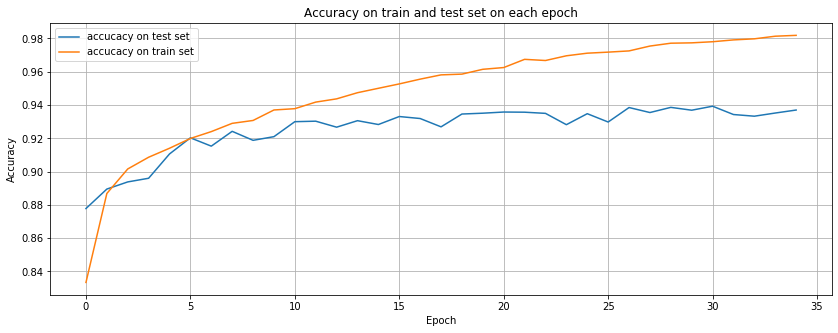

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[14, 5])
plt.plot(accuracy_history_test, label='accucacy on test set')
plt.plot(accuracy_history_train, label='accucacy on train set')
plt.legend(loc='best')
plt.title('Accuracy on train and test set on each epoch')
plt.grid('True')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [13]:
model = model.eval()

In [14]:
torch.save(model, 'FashionMNIST_ResNet.pth')

/home/matvey/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/matvey/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
quit()